In [3]:
import numpy as np
import nibabel as nib
import os
import sys
import pandas as pd
import yaml
from pathlib import Path
from glmsingle.glmsingle import GLM_single


def index_to_bold_file(task,run): #string,string
    #test_bold_file = '/tank/shared/2022/arrow_of_time/preproc7/sub-001/ses-pilot/func/sub-001_ses-pilot_task-'+task+'_acq-nordic_run-'+run+'_hemi-L_space-fsaverage_bold.func.gii'
    #test_bold_file = '/tank/shared/2022/arrow_of_time/postproc/truncate/sub-001/ses-pilot/func/sub-001_ses-pilot_task-'+task+'_acq-nordic_run-'+run+'_hemi-L_space-fsaverage_bold.func.gii'
    test_bold_file_L = '/tank/shared/2022/arrow_of_time/postproc/truncate/sub-001/ses-pilot/func/sub-001_ses-pilot_task-'+task+'_acq-nordic_run-'+run+'_hemi-L_space-fsaverage_bold.func.gii'
    test_bold_file_R = '/tank/shared/2022/arrow_of_time/postproc/truncate/sub-001/ses-pilot/func/sub-001_ses-pilot_task-'+task+'_acq-nordic_run-'+run+'_hemi-R_space-fsaverage_bold.func.gii'
    return test_bold_file_L,test_bold_file_R

def index_to_events_file(task,run):
    template = '/tank/shared/2022/arrow_of_time/aotpilot_copy/sub-001/ses-pilot/func/sub-001_ses-pilot_task-72_run-01_events.tsv'
    events_file = '/tank/shared/2022/arrow_of_time/aotpilot_copy/sub-001/ses-pilot/func/sub-001_ses-pilot_task-'+task+'_run-'+run+'_events.tsv'
    return events_file

#load and concatenate the bold data from left and right hemispheres
def merge_bold_data(test_bold_file_L,test_bold_file_R):
    
    img_L = nib.load(test_bold_file_L)
    img_data_L = [x.data for x in img_L.darrays]
    cur_data_L = img_data_L[0]
    #swap the first two dimensions
    cur_data_L = np.swapaxes(cur_data_L,0,1)
    print('bold data shape:',cur_data_L.shape)
    img_R = nib.load(test_bold_file_R)
    img_data_R = [x.data for x in img_R.darrays]
    cur_data_R = img_data_R[0]
    cur_data_R = np.swapaxes(cur_data_R,0,1)
    print('bold data shape:',cur_data_R.shape)
    cur_data = np.concatenate((cur_data_L,cur_data_R),axis=0)
    print('bold data shape:',cur_data.shape)
    return cur_data



label_index = {'onset':0,'duration':1,'event_type':2,'phase':3,'response':4,'nr_frames':5,'movie_index':6,'movie_duration':7,'movie_file':8,'blank':9,'onset_abs':10,'trial_nr':11}

def movies_conditions_dict():
    settings_sample_path = '/tank/shared/2022/arrow_of_time/arrow_of_time/aot/analysis/glmsingle/code/pilot_settings/movies.yml'
    settings_sample = yaml.load(open(settings_sample_path), Loader=yaml.FullLoader)
    movies  = settings_sample['stimuli']['movie_files']
    movies_conditions = {}
    condnum = 0
    movies_conditions["blank"] = condnum
    for i in range(len(movies)):
        if movies[i] not in movies_conditions and movies[i] != 'blank':
            condnum += 1
            movies_conditions[movies[i]] = condnum
    return movies_conditions

condition_dict = movies_conditions_dict()
len_conditions = len(condition_dict)
print(condition_dict)

def construct_design_for_one_run(eventfile):
    run_events = pd.read_csv(eventfile, delimiter='\t')
    run_events = run_events.values.tolist()
    run_design = []
    index_list = []

    last_trail_nr = -1
    for i in range(len(run_events)):
        repeat = False
        #print(run_events[i])
        new_trail_nr = run_events[i][label_index['trial_nr']]
        if run_events[i][label_index['event_type']] == 'pulse':
            if new_trail_nr == last_trail_nr:
                repeat = True
                last_trail_nr = new_trail_nr
            else:
                repeat = False
                last_trail_nr = new_trail_nr
            
            movie = run_events[i][label_index['movie_file']]
            if type(movie) == str:
                if movie.endswith('.mp4'):
                    movie = Path(movie)
                    #get the full name of the movie
                    movie = movie.name
                else:
                    movie = 'blank'
            else:
                movie = 'blank'
            #print(movie)
            if movie not in condition_dict:
                print('movie not in condition dict:', movie)
                movie = 'blank'

            if movie == 'blank':
                new_time_slice = [0] * len_conditions
                run_design.append(new_time_slice)
                index_list.append(0)
            else:
                if not repeat:
                    new_time_slice = [0] * len_conditions
                    new_time_slice[condition_dict[movie]] = 1
                    index_list.append(condition_dict[movie])
                elif repeat:
                    new_time_slice = [0] * len_conditions
                    index_list.append(0)
                run_design.append(new_time_slice)
    print("list design:",run_design)
    print("index list:",index_list)
    run_design = np.array(run_design)
    #print(run_design.shape)
    return run_design,index_list

def construct_design_for_all_runs(task):
    design_all_runs = []
    indexlist_all_runs = []
    for run in [1,2]:
        events_file = index_to_events_file(task,str(run).zfill(2))
        design_one_run,indexlist = construct_design_for_one_run(events_file)
        design_all_runs.append(design_one_run)
        indexlist_all_runs.append(indexlist)
        for i in range(len(design_all_runs)):
            print("len of design: ",len(design_all_runs[i]))
    return design_all_runs,indexlist_all_runs

def construct_bold_data_for_all_runs(task):
    bold_data_all_runs = []
    for run in [1,2]:
        test_bold_file_L,test_bold_file_R = index_to_bold_file(task,str(run).zfill(2))
        bold_data_one_run = merge_bold_data(test_bold_file_L,test_bold_file_R)
        bold_data_all_runs.append(bold_data_one_run)
    return bold_data_all_runs

def construct_output_dir(task):
    output_dir_base = '/tank/shared/2022/arrow_of_time/arrow_of_time/aot/analysis/glmsingle/output'
    output_dir = os.path.join(output_dir_base,task)
    return output_dir

def apply_glmsingle_for_one_task(task):
    design_all_runs,indexlist_all_runs = construct_design_for_all_runs(task)
    bold_data_all_runs = construct_bold_data_for_all_runs(task)
    output_dir = construct_output_dir(task)
    opt = dict()
    # set important fields for completeness (but these would be enabled by default)
    opt['wantlibrary'] = 1
    opt['wantglmdenoise'] = 1
    opt['wantfracridge'] = 1
    # for the purpose of this example we will keep the relevant outputs in memory
    # and also save them to the disk
    opt['wantfileoutputs'] = [1,1,1,1]
    opt['wantmemoryoutputs'] = [1,1,1,1]
    # running python GLMsingle involves creating a GLM_single object
    # and then running the procedure using the .fit() routine
    #set modelmd as full set of single trial regressors
    glmsingle_obj = GLM_single(opt)
    #glmsingle_obj.fit(design=design_all_runs,data=bold_data_all_runs,stimdur=2.5,tr=1.6,outputdir=output_dir)

def apply_glmsingle_for_all_tasks():
    task_list = ['72']#,'90','80']
    for task in task_list:
        apply_glmsingle_for_one_task(task)

def apply_glmsingle_for_all_together():
    design_all_runs = []
    indexlist_all_runs = []
    bold_data_all_runs = []
    for task in ['72','90','80']:
        design_all_runs,indexlist_all_run = construct_design_for_all_runs(task)
        design_all_runs.append(construct_design_for_all_runs(task))
        indexlist_all_runs.append(indexlist_all_run)
        bold_data_all_runs.append(construct_bold_data_for_all_runs(task))
    #flatten the list
    design_all_runs = [item for sublist in design_all_runs for item in sublist]
    bold_data_all_runs = [item for sublist in bold_data_all_runs for item in sublist]
    print('design_all_runs:',len(design_all_runs))
    print('bold_data_all_runs:',len(bold_data_all_runs))
    output_dir = construct_output_dir('all')
    opt = dict()
    opt['wantlibrary'] = 1
    opt['wantglmdenoise'] = 1
    opt['wantfracridge'] = 1
    opt['wantfileoutputs'] = [1,1,1,1]
    opt['wantmemoryoutputs'] = [1,1,1,1]
    glmsingle_obj = GLM_single(opt)
    #glmsingle_obj.fit(design=design_all_runs,data=bold_data_all_runs,stimdur=2.5,tr=1.6,outputdir=output_dir)




{'blank': 0, 'S_yt-6mRpmfIvdew_1435.mp4': 1, 'S_ILSVRC2015_train_00515000.mp4': 2, 'S_yt-oxUpc8I5wWQ_238.mp4': 3, 'S_WCwb-DeQOSg_85.mp4': 4, 'S_ILSVRC2015_train_00594001.mp4': 5, 'S_yt-9Ow95khYa_M_91.mp4': 6, 'S_yt-aiWUhl8MCto_71.mp4': 7, 'S_yt-UzWRbs9Syf4_7.mp4': 8, 'S_flickr-clarkstonscamp-4863427159_1.mp4': 9, 'S_yt--OkafQ5VFHs_51.mp4': 10, 'S_yt-QqSceHxY3d0_356.mp4': 11, 'S_yt-EvKV7iY1_HM_193.mp4': 12, 'S_yt-vQ-rd-1gwH4_238.mp4': 13, 'S_yt-ieA3XwoSko4_98.mp4': 14, 'S_yt-deiWoIfK6vg_44.mp4': 15, 'S_yt-6vkiJedss6g_5.mp4': 16, 'S_production_ID_5119260.mp4': 17, 'S_yt-PaxmJhMoP3w_87.mp4': 18, 'S_wc-8bTJmWfuVyJ4_8.mp4': 19, 'S_yt-t8NfuFA7OlM_26.mp4': 20, 'S_yt-hTkrnNr39dk_202.mp4': 21, 'S_yt-AiXq1oDrEXI_123.mp4': 22, 'S_yt-b7JAHOeiTqU_44.mp4': 23, 'S_production_ID_4707837.mp4': 24, 'S_production_ID_3735542.mp4': 25, 'S_yt-gmiyqQDGN78_7.mp4': 26, 'S_Nh81j72Utbs_5.mp4': 27, 'S_ILSVRC2015_train_00165008.mp4': 28, 'S_Pexels_Videos_2786546.mp4': 29, 'S_yt-9EnchawJ3pA_90.mp4': 30, 'S_xq822dX6

list design: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

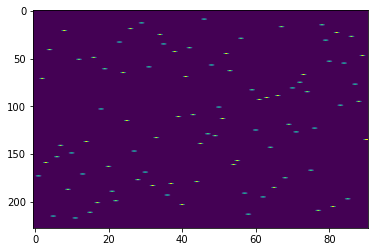

In [11]:
tasks = ['72','90','80']
design_72,indexlist72 = construct_design_for_all_runs('72')
design_90,indexlist90 = construct_design_for_all_runs('90')
design_80,indexlist80 = construct_design_for_all_runs('80')

#draw the design matrix
import matplotlib.pyplot as plt
plt.imshow(design_90[1],aspect='auto')



In [9]:
np.unique(indexlist80)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55,
       56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90])

In [12]:
import glmsingle

In [15]:
glmsingle.GLM_single?

Init signature: glmsingle.GLM_single(params=None)
Docstring:      <no docstring>
Init docstring:
glm singletrial denoise constructor

 This function computes up to four model outputs (called type-A (ONOFF),
 type-B (FITHRF), type-C (FITHRF_GLMDENOISE), and type-D
 (FITHRF_GLMDENOISE_RR)),and either saves the model outputs to disk,
 or returns them in <results>, or both,depending on what the user
 specifies.

 There are a variety of cases that you can achieve. Here are some
 examples:

 - wantlibrary=1, wantglmdenoise=1, wantfracridge=1 [Default]
     A = simple ONOFF model
     B = single-trial estimates using a tailored HRF for every voxel
     C = like B but with GLMdenoise regressors added into the model
     D = like C but with ridge regression regularization (tailored to
         each voxel)

 - wantlibrary=0
     A fixed assumed HRF is used in all model types.

 - wantglmdenoise=0, wantfracridge=0
     Model types C and D are not computed.

 - wantglmdenoise=0, wantfracridge=1
  